In [1]:
from typing import Union
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def uniform_initializer(low, high, shape):
    return np.random.uniform(low, high, shape)

In [4]:
def squared_reconstruction_error(y1, y2):
    return 1 / 2 * np.sum((y1 - y2) ** 2)

In [5]:
def add_bias(x):
    shape = list(x.shape)
    shape[-1] = 1
    bias = np.ones(shape)
    return np.hstack((x, bias))


In [6]:
class Recirculation:
    ACTIVATIONS = {
        'logistic': logistic
    }

    INITIALIZERS = {
        'uniform': uniform_initializer
    }

    def __init__(self, input_len: int, hidden_units: Union[int, list], regression_rate: float, learning_rate: float,
                 activation_function: str, weight_initializer: str, low_weight_range: float = -0.5,
                 high_weight_range: float = 0.5):
        if type(hidden_units) is int:
            hidden_units = [hidden_units]

        self.activation_function = self.ACTIVATIONS[activation_function]
        self.weight_initializer = self.INITIALIZERS[weight_initializer]
        self.regression_rate = regression_rate
        self.learning_rate = learning_rate

        self.layer_shapes = [input_len] * 2
        for unit in hidden_units:
            self.layer_shapes.insert(-1, unit)

        self.layer_count = len(self.layer_shapes)

        self.weights = []
        for i in range(self.layer_count - 1):
            self.weights.append(
                self.weight_initializer(
                    low_weight_range, high_weight_range,
                    # adding one to the first shape is because of the bias
                    (self.layer_shapes[i] + 1, self.layer_shapes[i + 1])
                )
            )

    def fit(self, x: np.ndarray, epoch: int = 100) -> dict:
        history = {
            'error': [],
        }

        for _ in range(epoch):
            layer_outputs = [x]
            # first pass
            # calculate hidden layer outputs (based on equation 1, 2)
            for i in range(self.layer_count - 2):
                layer_outputs.append(
                    self.activation_function(
                        add_bias(layer_outputs[-1]) @ self.weights[i]
                    )
                )
            # calculate output with regression (based on equation 5)
            layer_outputs.append(
                self.regression_rate * layer_outputs[0] + (1 - self.regression_rate) *
                self.activation_function(
                    add_bias(layer_outputs[-1]) @ self.weights[-1]
                )
            )
            # note: the above statement can be inside the for loop below but this is more readable

            # second pass
            # calculate hidden layer outputs (based on equation 6)
            for i in range(1, self.layer_count - 1):
                layer_outputs.append(
                    self.regression_rate * layer_outputs[i] + (1 - self.regression_rate) *
                    self.activation_function(
                        add_bias(layer_outputs[-1]) @ self.weights[i - 1]
                    )
                )

            # compute reconstruction error
            error = squared_reconstruction_error(layer_outputs[0], layer_outputs[self.layer_count - 1])

            # updating weights (based on equations 3, 4)
            for i in range(self.layer_count - 1):
                delta_w = self.learning_rate * add_bias(layer_outputs[i + 1]).T @ (
                        layer_outputs[i] - layer_outputs[i + 2])
                self.weights[len(self.weights) - 1 - i] += delta_w

            # update history
            history['error'].append(error)

        return history

    def predict(self, x: np.ndarray) -> np.ndarray:
        layer_output = [x]
        for i in range(self.layer_count - 1):
            layer_output.append(
                self.activation_function(
                    add_bias(layer_output[-1]) @ self.weights[i]
                )
            )
        return layer_output[-1]

    def predict_class(self, x: np.ndarray) -> np.ndarray:
        pred = self.predict(x)
        classes = np.zeros_like(pred)
        classes[np.arange(len(classes)), pred.argmax(axis=1)] = 1
        return classes


In [7]:
x = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
])

In [8]:
parameters = {
    'input_len': 4,
    'hidden_units': 2,
    'regression_rate': 0.75,
    'learning_rate': 1,
    'activation_function': 'logistic',
    'weight_initializer': 'uniform',
    'low_weight_range': -0.5,
    'high_weight_range': 0.5,
}

In [9]:
r = Recirculation(**parameters)

In [10]:
history = r.fit(x)

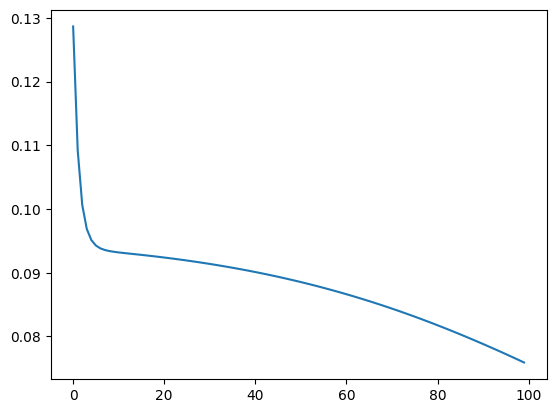

In [11]:
plt.plot(np.arange(100), np.array(history['error']))

In [12]:
r.predict_class(x)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [13]:
r.predict(x)

array([[0.27853198, 0.25485571, 0.20305892, 0.20569306],
       [0.267641  , 0.29356115, 0.14942627, 0.26621219],
       [0.252858  , 0.19372109, 0.42090434, 0.18394815],
       [0.24174352, 0.30526303, 0.16107745, 0.33842269]])